# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계3 : Text classification

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * Machine Learning
>> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
> * Deep Learning
>> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
>> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
>> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)
>> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 2s (3,895 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

## 1. 개발 환경 설정

### 1-1. 라이브러리 설치

In [2]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.6/575.6 KB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 16.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=9a248d1822c7050f109ef2a28634d0a33651050e356f296088c7984d2e8be4b9
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


### 1-2. 라이브러리 import

In [3]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget,os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import wget,os

In [4]:
import tensorflow as tf
import numpy as np
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

seed = 42
my_seed_everywhere(seed)

### 1-4. 구글드라이브 연결(Colab)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 전처리한 데이터 불러오기
* 1, 2일차에 전처리한 데이터를 불러옵니다.
* sparse data에 대해서는 scipy.sparse.load_npz 활용

In [6]:
import scipy
data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/'
bigram_x_train = scipy.sparse.load_npz(data_path + 'bigram_x_train.npz').toarray()
bigram_x_val = scipy.sparse.load_npz(data_path + 'bigram_x_val.npz').toarray()
y_train = pd.read_csv(data_path + 'y_train.csv')['label']
y_val = pd.read_csv(data_path + 'y_val.csv')['label']
bigram_x_train.shape, bigram_x_val.shape, y_train.shape, y_val.shape

((2964, 55837), (742, 55837), (2964,), (742,))

In [7]:
seq_x_train = np.load(data_path + 'seq_x_train.npy')
seq_x_val = np.load(data_path + 'seq_x_val.npy')
seq_x_train.shape, seq_x_val.shape

((2964, 400), (742, 400))

In [8]:
w2v_x_train = np.load(data_path +'w2v_x_train.npy')
w2v_x_val = np.load(data_path +'w2v_x_val.npy')
w2v_x_train.shape, w2v_x_val.shape

((2964, 100), (742, 100))

## BERT

In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.2 MB/s eta 0:00:00


In [10]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time
import datetime

from sklearn.metrics import confusion_matrix, classification_report

In [11]:
data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/train.csv'
data = pd.read_csv(data_path)

X = data.loc[:, 'text']
Y = data.loc[:, 'label']

label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}
Y = Y.replace(label_dict)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2023, stratify=Y)

In [12]:
# Bert 용 전처리
train_sentences = ['[CLS] ' + str(s) + ' [SEP]' for s in x_train]
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_train = [tokenizer.tokenize(s) for s in train_sentences]
ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]

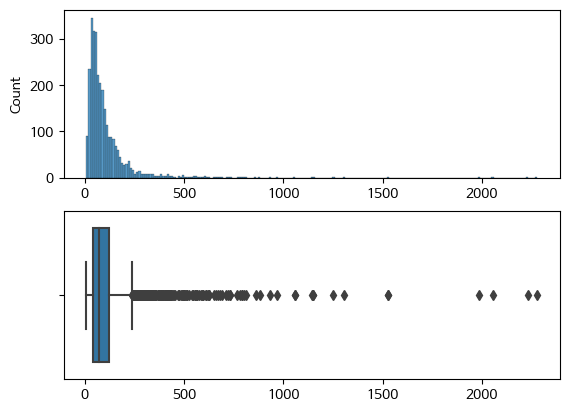

count    2964.000000
mean      107.767206
std       141.862474
min         8.000000
25%        43.000000
50%        71.000000
75%       122.000000
max      2278.000000
dtype: float64

In [13]:
temp = [len(x) for x in ids_train]
plt.subplot(2, 1, 1)
sns.histplot(temp)
plt.subplot(2, 1, 2)
sns.boxplot(x=temp)
plt.show()
pd.Series(temp).describe()

In [14]:
MAX_LEN = 256 # 최대 길이
pad_train = pad_sequences(
    ids_train, maxlen=MAX_LEN, dtype="long", padding="post", truncating="post"
)

In [15]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(pad_train, y_train.values, random_state=2023, test_size=0.1)

In [16]:
# Attention Mask 만들기
# 단어 부분은 1, 0으로 패딩된 부분은 0
attention_masks_train = []
for seq in train_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_train.append(seq_mask)

attention_masks_val = []
for seq in val_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_val.append(seq_mask)

In [17]:
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(attention_masks_train)
train_labels = torch.tensor(train_labels)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(attention_masks_val)
val_labels = torch.tensor(val_labels)

In [18]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [19]:
## Test Set 전처리

# [CLS] + 문장 + [SEP]
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in x_test]

# 라벨 데이터
labels = y_test.values

# Word 토크나이저 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 시퀀스 설정 및 정수 인덱스 변환 & 패딩
MAX_LEN = 256
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# 파이토치 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 배치 사이즈 설정 및 데이터 설정
batch_size = 32
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [20]:
# GPU 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [21]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=5)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [22]:
# 옵티마이저
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률(learning rate)
                  eps = 1e-8 
                )

# 에폭수
epochs = 100

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
#랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 시각화를 위한 결과 값 저장
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

## Early Stopping
best_acc = 0  
patience_limit = 10  # 몇 번 지켜볼지
patience_check = 0   # 현재 몇 epoch 연속으로 accuracy 개선이 안되는지 기록

#그래디언트 초기화
model.zero_grad()

# 학습
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
    
    # 변수 초기화
    train_accuracy, nb_train_steps = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

        # # CPU로 데이터 이동
        # logits = loss.detach().cpu().numpy()
        # label_ids = b_labels.to('cpu').numpy()
        
        # # 출력 로짓과 라벨을 비교하여 정확도 계산
        # tmp_train_accuracy = flat_accuracy(logits, label_ids)
        # train_accuracy += tmp_train_accuracy
        # nb_train_steps += 1

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    # avg_train_acc = train_accuracy/nb_train_steps
    train_loss_list.append(avg_train_loss)
    # train_acc_list.append(avg_train_acc)

    print("")
    # print("  Average training Accuracy: {0:.2f}".format(avg_train_acc))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    val_loss, val_accuracy = 0, 0
    nb_val_steps, nb_val_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]
        # val_loss += logits.item()
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_val_accuracy = flat_accuracy(logits, label_ids)
        val_accuracy += tmp_val_accuracy
        nb_val_steps += 1

    # avg_val_loss = val_loss / len(val_dataloader)
    avg_val_acc = val_accuracy/nb_val_steps
    # val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    print("  Validation Accuracy: {0:.2f}".format(avg_val_acc))
    # print("  Validation loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Early Stopping
    if avg_val_acc < best_acc: # accuracy 개선 되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit:
            print("Early Stopping !!!")
            break
    else: # accuracy 개선
        best_acc = avg_val_acc
        patience_check = 0

print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...

  Average training loss: 1.05
  Training epcoh took: 0:01:50

Running Validation...
  Validation Accuracy: 0.67
  Validation took: 0:00:05

======== Epoch 2 / 100 ========
Training...

  Average training loss: 0.61
  Training epcoh took: 0:01:52

Running Validation...
  Validation Accuracy: 0.76
  Validation took: 0:00:05

======== Epoch 3 / 100 ========
Training...

  Average training loss: 0.39
  Training epcoh took: 0:01:52

Running Validation...
  Validation Accuracy: 0.81
  Validation took: 0:00:05

======== Epoch 4 / 100 ========
Training...

  Average training loss: 0.26
  Training epcoh took: 0:01:52

Running Validation...
  Validation Accuracy: 0.82
  Validation took: 0:00:05

======== Epoch 5 / 100 ========
Training...

  Average training loss: 0.17
  Training epcoh took: 0:01:52

Running Validation...
  Validation Accuracy: 0.81
  Validation took: 0:00:05

======== Epoch 6 / 100 ========
Training...

  Average training loss: 0.12

In [26]:
## Test Set
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.82
Test took: 0:00:12


In [25]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

def test_sentences(sentences):
    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [27]:
y_pred = test_sentences(x_test)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       317
           1       0.89      0.83      0.86       147
           2       0.76      0.71      0.73       146
           3       0.79      0.83      0.81       112
           4       0.76      0.95      0.84        20

    accuracy                           0.82       742
   macro avg       0.81      0.84      0.82       742
weighted avg       0.82      0.82      0.82       742

